In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fft, fftfreq, fftshift, ifft, ifftshift
from scipy.integrate import simpson
import pandas as pd
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML

# Oppgave 4

## 2)

In [3]:
def cahn_hilliard_backward_euler(*, kappa, X, Y, U0, t0, T, Nt, g, alpha=1.5):
    x, y = X[0,:], Y[:,0]
    if Nx < 2 or Ny < 2:
        raise ValueError('Grids must have at least two points in each space direction!')
    dx, dy = x[1]-x[0], y[1]-y[0]
    
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    K2 = KX**2 + KY**2
    K4 = K2**2
    
    t = t0
    dt = (T-t0)/Nt
    
    U_hat = fft2(U0)
    
    yield(U_hat, t) 
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t+dt))
            else:
                G_hat = 0
            
            U = ifft2(U_hat)
            N_U = np.array(U)**3
            N_U_hat = fft2(N_U)
            U_hat = (U_hat + dt*((1+alpha)*K2*U_hat - K2*N_U_hat + G_hat))/(1 + dt*(kappa*K4 + alpha*K2))
    
            t += dt
            
            pbar.update(dt)
            yield (U_hat, t)

# Oppgave 5

## 3)

In [55]:
def cahn_hilliard_backward_euler_improved(*, kappa, X, Y, U0, t0, T, Nt, g, alpha=1.5):
    x, y = X[0,:], Y[:,0]
    if Nx < 2 or Ny < 2:
        raise ValueError('Grids must have at least two points in each space direction!')
    dx, dy = x[1]-x[0], y[1]-y[0]
    
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    K2 = KX**2 + KY**2
    K4 = K2**2
    
    t = t0
    dt = (T-t0)/Nt
    
    U_hat = fft2(U0)
    
    yield(U_hat, t) 
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t+dt/2))
            else:
                G_hat = 0
            
            U = ifft2(U_hat)
            N_U = np.array(U)**3
            N_U_hat = fft2(N_U)
            U1_hat = (U_hat + dt*((1+alpha)*K2*U_hat - K2*N_U_hat + G_hat))/(1 + dt*(kappa*K4 + alpha*K2))
            
            U1 = ifft2(U1_hat)
            N_U1 = np.array(U1)**3
            N_U1_hat = fft2(N_U1)
            U2_hat = (α10*U_hat + α11*U1_hat + β1*dt*((1+alpha)*K2*U1_hat - K2*N_U1_hat + G_hat))/(1 + β1*dt*(kappa*K4 + alpha*K2))
            
            U2 = ifft2(U2_hat)
            N_U2 = np.array(U2)**3
            N_U2_hat = fft2(N_U2)
            U_hat = (α20*U_hat + α21*U1_hat + α22*U2_hat + β2*dt*((1+alpha)*K2*U2_hat - K2*N_U2_hat + G_hat))/(1 + β2*dt*(kappa*K4 + alpha*K2))
        
            t += dt
            
            pbar.update(dt)
            yield (U_hat, t)

# Oppgave 6

In [7]:
g = None

In [8]:
kappa = 0.0025**2

Lx, Ly = 0.5, 0.5
Nx, Ny = 256, 256
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, sparse=True)

Tl, Tk = 4.0, 0.01
dtl, dtk = 10**(-3), 10**(-4)

Ntll = (Tl-t0)/dtl
Ntlk = (Tl-t0)/dtk
Ntkl = (Tk-t0)/dtl
Ntkk = (Tk-t0)/dtk

In [9]:
rng = np.random.default_rng(12345)
noise = 0.05
u0_base = 0.0
U0 = np.ones_like((Ny, Nx))

U0_first = np.full((Ny, Nx), u0_base) + noise*rng.standard_normal((Ny, Nx))
U0_second = U0_first - 0.45

### T4, U0_first, dtl

In [26]:
solver_fll = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntll, g=g)
dx, dy = x[1]-x[0], y[1]-y[0]
m_fll = []
t_fll = []
for U_hat,t in solver_fll:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_fll.append(m)
    t_fll.append(t)

100%|█████████▉| 3.9999999999996705/4.0 [01:14<00:00, 18.61s/it]  


In [146]:
solver_fll = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntll, g=g)
Eint_fll = []
Emix_fll = []
Etot_fll = []
for U_hat,t in solver_fll:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_fll.append(Eint)
    Emix_fll.append(Emix)
    Etot_fll.append(Etot)

100%|█████████▉| 3.9999999999996705/4.0 [01:36<00:00, 24.06s/it]  


In [212]:
solver_fll = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntll, g=g)
nSnap = 300
r = int(Ntll/nSnap)
snap_fll = []
count = 0
for U_hat,t in solver_fll:
    if count % r == 0:
        U = ifft2(U_hat).real
        snap_fll.append(U)
    count += 1

100%|█████████▉| 3.9999999999996705/4.0 [00:42<00:00, 10.54s/it] 


In [214]:
solver_fll2 = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntll, g=g)
Ntll2 = int(Ntll/10)
r = int(Ntll2/nSnap)
snap_fll2 = []
count = 0
for U_hat,t in solver_fll2:
    if t < Tl/10:
        if count % r == 0:
            U = ifft2(U_hat).real
            snap_fll2.append(U)
    count += 1

100%|█████████▉| 3.9999999999996705/4.0 [00:41<00:00, 10.32s/it]  


In [216]:
# fig, ax = plt.subplots()
# im = ax.imshow(snap_fll2[0], cmap='RdBu', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
# fig.colorbar(im)

# def update(frame):
#     im.set_data(snap_fll2[frame])
#     return [im]

# ani = animation.FuncAnimation(fig, update, frames=len(snap_fll2), blit=True, interval=50)

# # plt.show()

# ani.to_jshtml()
# html_animation = ani.to_jshtml()
# display(HTML(html_animation))

In [217]:
# fig, ax = plt.subplots()
# im = ax.imshow(snap_fll[0], cmap='RdBu', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
# fig.colorbar(im)

# def update(frame):
#     im.set_data(snap_fll[frame])
#     return [im]

# ani = animation.FuncAnimation(fig, update, frames=len(snap_fll), blit=True, interval=50)

# # plt.show()

# ani.to_jshtml()
# html_animation = ani.to_jshtml()
# display(HTML(html_animation))

In [14]:
tll = np.linspace(t0,Tl,int(Ntll)+1)

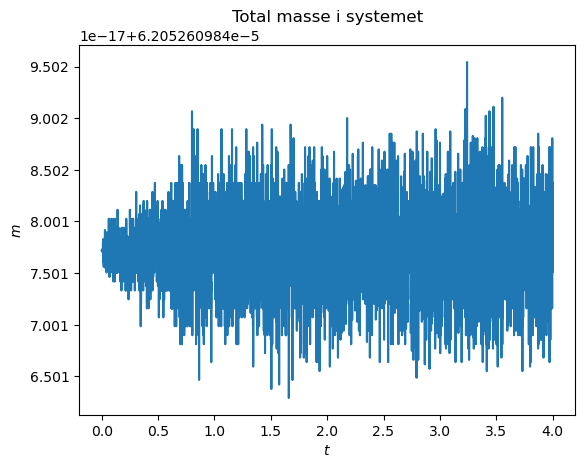

In [91]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tll,m_fll)
plt.show()

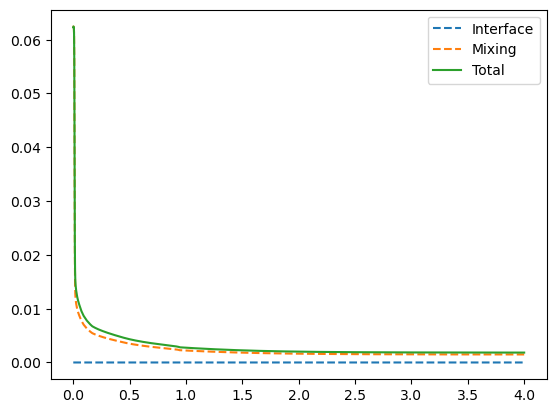

In [148]:
plt.plot(tll,Eint_fll,'--',label='Interface')
plt.plot(tll,Emix_fll,'--',label='Mixing')
plt.plot(tll,Etot_fll,label='Total')
plt.legend(); plt.show()

In [40]:
print(max(m_fll)-min(m_fll))

3.252606517456513e-17


### T4, U0_first, dtk

In [41]:
solver_flk = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntlk, g=g)
m_flk = []
t_flk = []
for U_hat,t in solver_flk:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_flk.append(m)
    t_flk.append(t)

100%|██████████| 4.000000000004016/4.0 [10:12<00:00, 153.10s/it]    


In [149]:
solver_flk = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntlk, g=g)
Eint_flk = []
Emix_flk = []
Etot_flk = []
for U_hat,t in solver_flk:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_flk.append(Eint)
    Emix_flk.append(Emix)
    Etot_flk.append(Etot)

100%|██████████| 4.000000000004016/4.0 [16:17<00:00, 244.41s/it]    


In [16]:
tlk = np.linspace(t0, Tl, int(Ntlk)+1)

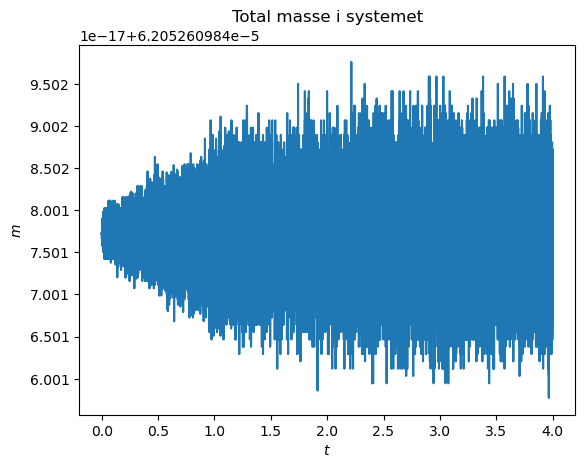

In [90]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tlk,m_flk)
plt.show()

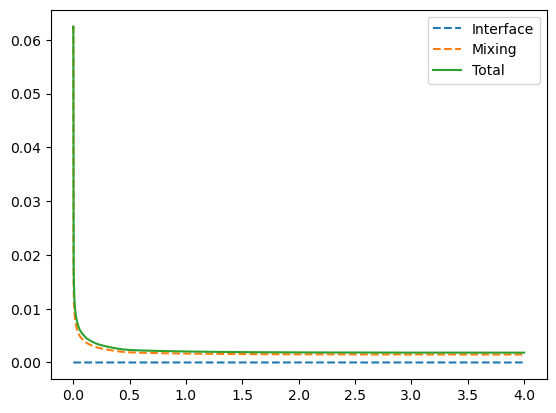

In [150]:
plt.plot(tlk,Eint_flk,'--',label='Interface')
plt.plot(tlk,Emix_flk,'--',label='Mixing')
plt.plot(tlk,Etot_flk,label='Total')
plt.legend(); plt.show()

In [140]:
print(min(m_flk), max(m_flk))

6.205260983595771e-05 6.205260983599761e-05


### T4, U0_second, dtl

In [47]:
solver_sll = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntll, g=g)
m_sll = []
t_sll = []
for U_hat,t in solver_sll:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_sll.append(m)
    t_sll.append(t)

100%|█████████▉| 3.9999999999996705/4.0 [00:48<00:00, 12.06s/it]  


In [151]:
solver_sll = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntll, g=g)
Eint_sll = []
Emix_sll = []
Etot_sll = []
for U_hat,t in solver_sll:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_sll.append(Eint)
    Emix_sll.append(Emix)
    Etot_sll.append(Etot)

100%|█████████▉| 3.9999999999996705/4.0 [01:42<00:00, 25.58s/it]  


In [141]:
print(min(m_sll), max(m_sll))

-0.11243794739016406 -0.11243794739016401


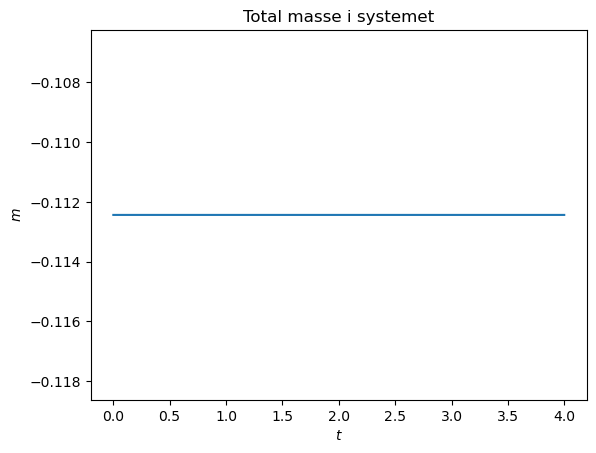

In [139]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tll,m_sll)
plt.show()

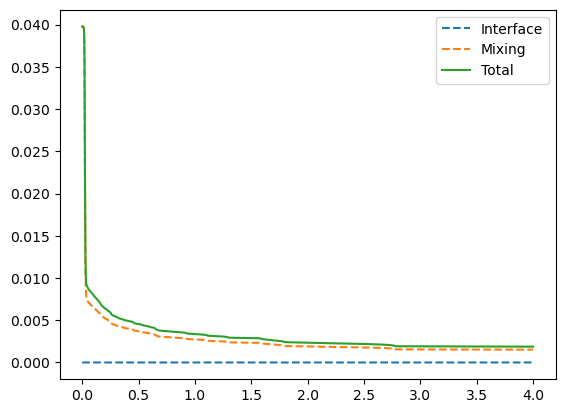

In [152]:
plt.plot(tll,Eint_sll,'--',label='Interface')
plt.plot(tll,Emix_sll,'--',label='Mixing')
plt.plot(tll,Etot_sll,label='Total')
plt.legend(); plt.show()

In [49]:
print(max(m_sll)-min(m_sll))

5.551115123125783e-17


### T4, U0_second, dtk

In [50]:
solver_slk = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntlk, g=g)
m_slk = []
t_slk = []
for U_hat,t in solver_slk:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_slk.append(m)
    t_slk.append(t)

100%|██████████| 4.000000000004016/4.0 [07:39<00:00, 114.97s/it]    


In [153]:
solver_slk = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntlk, g=g)
Eint_slk = []
Emix_slk = []
Etot_slk = []
for U_hat,t in solver_slk:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_slk.append(Eint)
    Emix_slk.append(Emix)
    Etot_slk.append(Etot)

100%|██████████| 4.000000000004016/4.0 [16:13<00:00, 243.38s/it]    


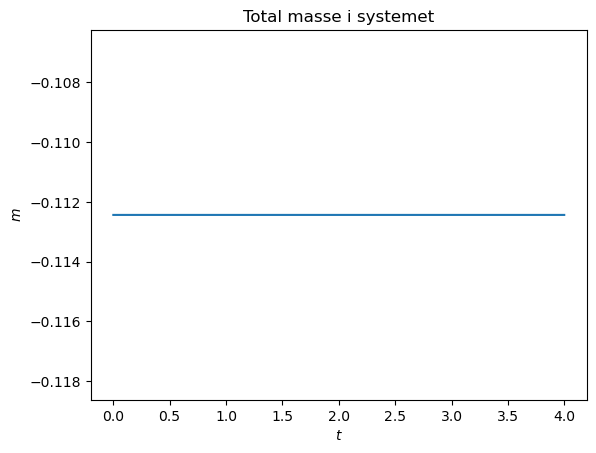

In [88]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tlk,m_slk)
plt.show()

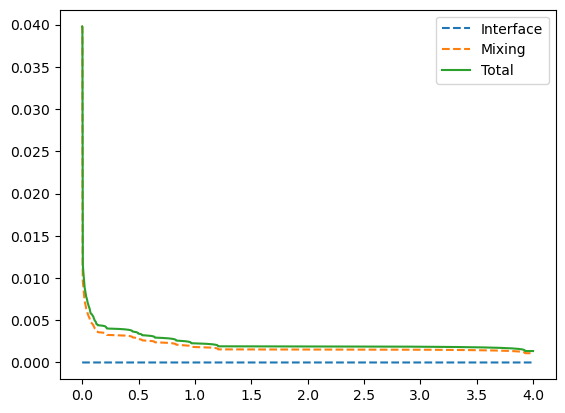

In [154]:
plt.plot(tlk,Eint_slk,'--',label='Interface')
plt.plot(tlk,Emix_slk,'--',label='Mixing')
plt.plot(tlk,Etot_slk,label='Total')
plt.legend(); plt.show()

In [52]:
print(max(m_slk)-min(m_slk))

8.326672684688674e-17


### T5, U0_first, dtl

In [53]:
α10 = 3/2
α11 = -1/2
α20 = 0
α21 = 0
α22 = 1
β1 = 1/2
β2 = 1

In [56]:
solver_fll_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntll, g=g)
m_fll_imp = []
t_fll_imp = []
for U_hat,t in solver_fll_imp:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_fll_imp.append(m)
    t_fll_imp.append(t)

100%|█████████▉| 3.9999999999996705/4.0 [02:20<00:00, 35.15s/it]  


In [164]:
solver_fll_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntll, g=g)
Eint_fll_imp = []
Emix_fll_imp = []
Etot_fll_imp = []
for U_hat,t in solver_fll_imp:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_fll_imp.append(Eint)
    Emix_fll_imp.append(Emix)
    Etot_fll_imp.append(Etot)

100%|█████████▉| 3.9999999999996705/4.0 [03:05<00:00, 46.29s/it]  


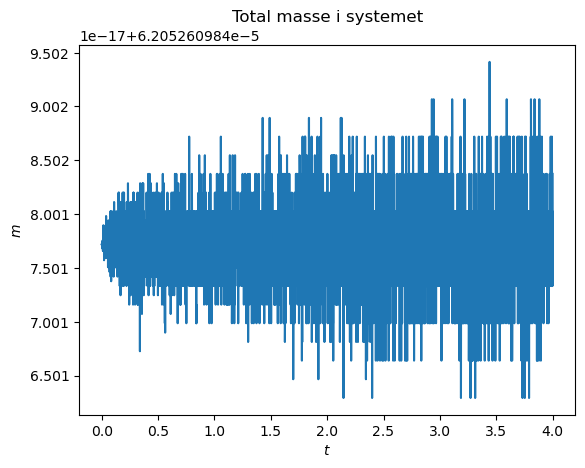

In [87]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tll,m_fll_imp)
plt.show()

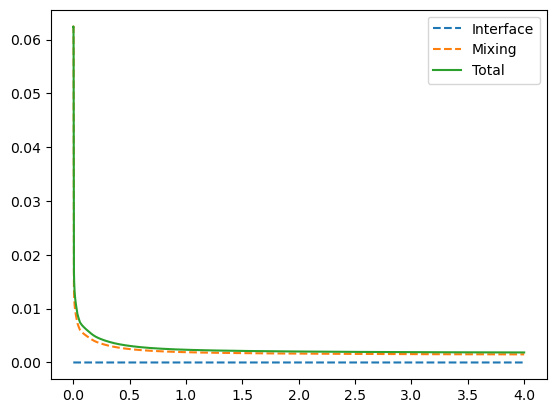

In [165]:
plt.plot(tll,Eint_fll_imp,'--',label='Interface')
plt.plot(tll,Emix_fll_imp,'--',label='Mixing')
plt.plot(tll,Etot_fll_imp,label='Total')
plt.legend(); plt.show()

In [58]:
print(max(m_fll_imp)-min(m_fll_imp))

3.122502256758253e-17


### T5, U0_first, dtk

In [59]:
solver_flk_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntlk, g=g)
m_flk_imp = []
t_flk_imp = []
for U_hat,t in solver_flk_imp:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_flk_imp.append(m)
    t_flk_imp.append(t)

100%|██████████| 4.000000000004016/4.0 [23:36<00:00, 354.10s/it]    


In [166]:
solver_flk_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_first, t0=t0, T=Tl, Nt=Ntlk, g=g)
Eint_flk_imp = []
Emix_flk_imp = []
Etot_flk_imp = []
for U_hat,t in solver_flk_imp:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_flk_imp.append(Eint)
    Emix_flk_imp.append(Emix)
    Etot_flk_imp.append(Etot)

100%|██████████| 4.000000000004016/4.0 [29:39<00:00, 444.79s/it]     


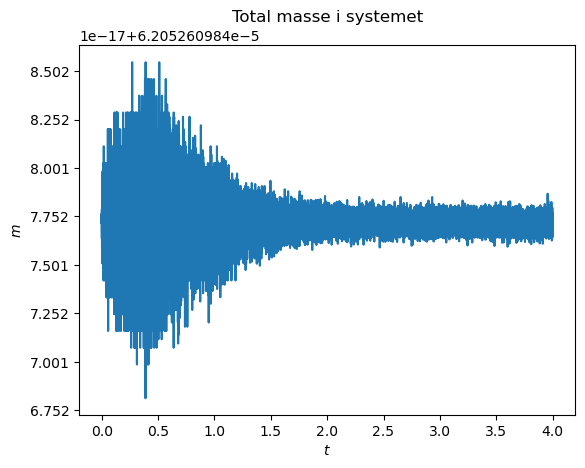

In [86]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tlk,m_flk_imp)
plt.show()

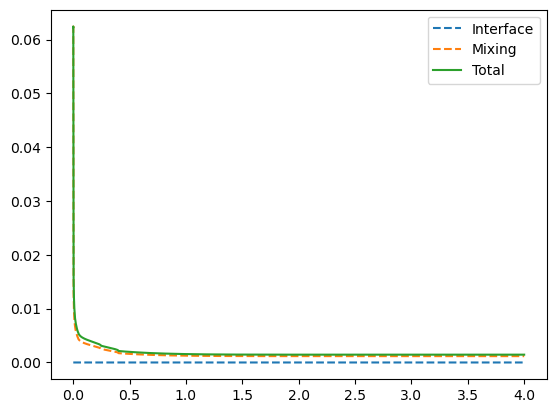

In [167]:
plt.plot(tlk,Eint_flk_imp,'--',label='Interface')
plt.plot(tlk,Emix_flk_imp,'--',label='Mixing')
plt.plot(tlk,Etot_flk_imp,label='Total')
plt.legend(); plt.show()

In [61]:
print(max(m_flk_imp)-min(m_flk_imp))

1.734723475976807e-17


### T5, U0_second, dtl

In [62]:
solver_sll_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntll, g=g)
m_sll_imp = []
t_sll_imp = []
for U_hat,t in solver_sll_imp:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_sll_imp.append(m)
    t_sll_imp.append(t)

100%|█████████▉| 3.9999999999996705/4.0 [02:20<00:00, 35.00s/it]  


In [168]:
solver_sll_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntll, g=g)
Eint_sll_imp = []
Emix_sll_imp = []
Etot_sll_imp = []
for U_hat,t in solver_sll_imp:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_sll_imp.append(Eint)
    Emix_sll_imp.append(Emix)
    Etot_sll_imp.append(Etot)

100%|█████████▉| 3.9999999999996705/4.0 [02:56<00:00, 44.03s/it]  


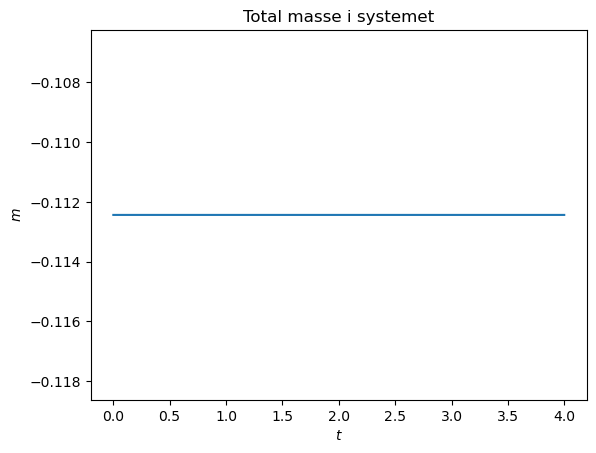

In [63]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tll,m_sll_imp)
plt.show()

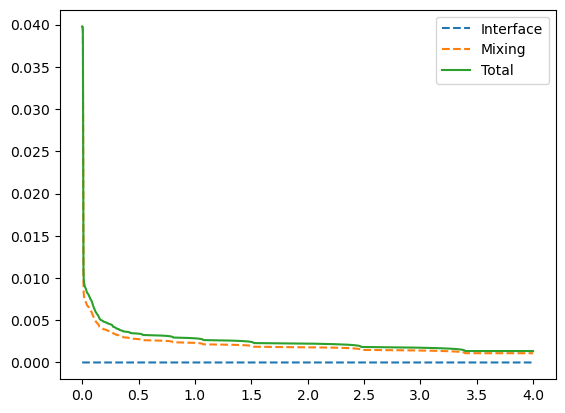

In [169]:
plt.plot(tll,Eint_sll_imp,'--',label='Interface')
plt.plot(tll,Emix_sll_imp,'--',label='Mixing')
plt.plot(tll,Etot_sll_imp,label='Total')
plt.legend(); plt.show()

In [64]:
print(max(m_sll_imp)-min(m_sll_imp))

6.938893903907228e-17


### T5, U0_second, dtk

In [65]:
solver_slk_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntlk, g=g)
m_slk_imp = []
t_slk_imp = []
for U_hat,t in solver_slk_imp:
    U = ifft2(U_hat).real
    m = np.sum(U)*dx*dy
    m_slk_imp.append(m)
    t_slk_imp.append(t)

100%|██████████| 4.000000000004016/4.0 [23:22<00:00, 350.54s/it]     


In [170]:
solver_slk_imp = cahn_hilliard_backward_euler_improved(kappa=kappa, X=X, Y=Y, U0=U0_second, t0=t0, T=Tl, Nt=Ntlk, g=g)
Eint_slk_imp = []
Emix_slk_imp = []
Etot_slk_imp = []
for U_hat,t in solver_slk_imp:
    U = ifft2(U_hat).real
    
    EintI = (kappa*np.linalg.norm(np.gradient(U))**2)/2
    Eint = np.sum(EintI)*dx*dy
    
    EmixI = ((U**2 - 1)**2)/4
    Emix = np.sum(EmixI)*dx*dy
    
    EtotI = EintI + EmixI
    Etot = np.sum(EtotI)*dx*dy
    
    Eint_slk_imp.append(Eint)
    Emix_slk_imp.append(Emix)
    Etot_slk_imp.append(Etot)

100%|██████████| 4.000000000004016/4.0 [54:29<00:00, 817.43s/it]         


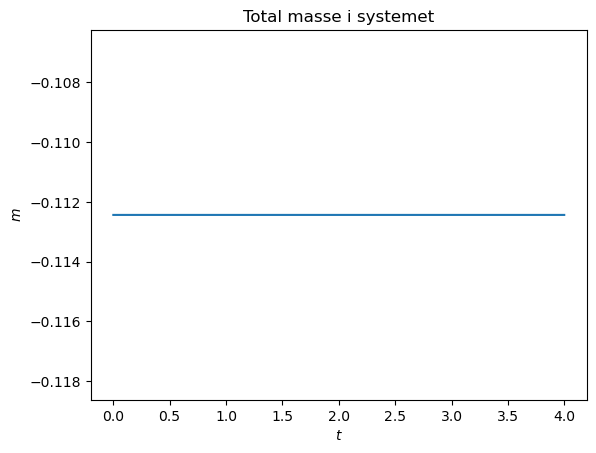

In [66]:
plt.title('Total masse i systemet')
plt.xlabel(r'$t$'); plt.ylabel(r'$m$')
plt.plot(tlk,m_slk_imp)
plt.show()

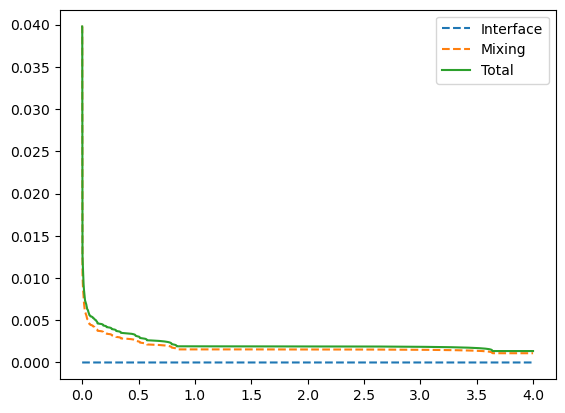

In [171]:
plt.plot(tlk,Eint_slk_imp,'--',label='Interface')
plt.plot(tlk,Emix_slk_imp,'--',label='Mixing')
plt.plot(tlk,Etot_slk_imp,label='Total')
plt.legend(); plt.show()

In [67]:
print(max(m_slk_imp)-min(m_slk_imp))

9.71445146547012e-17


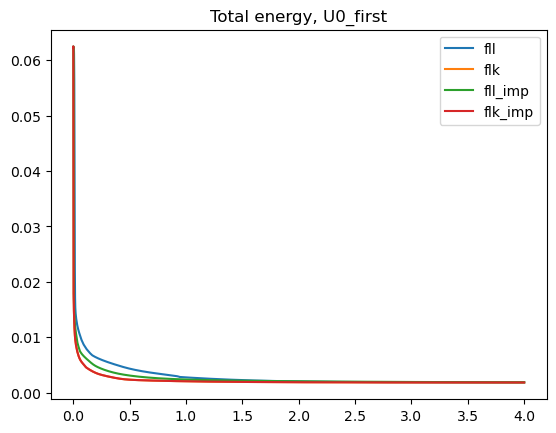

In [180]:
plt.plot(tll,Etot_fll,label='fll')
plt.plot(tlk,Etot_flk,label='flk')
plt.plot(tll,Etot_fll_imp,label='fll_imp')
plt.plot(tlk,Etot_flk,label='flk_imp')
plt.title('Total energy, U0_first')
plt.legend(); plt.show()

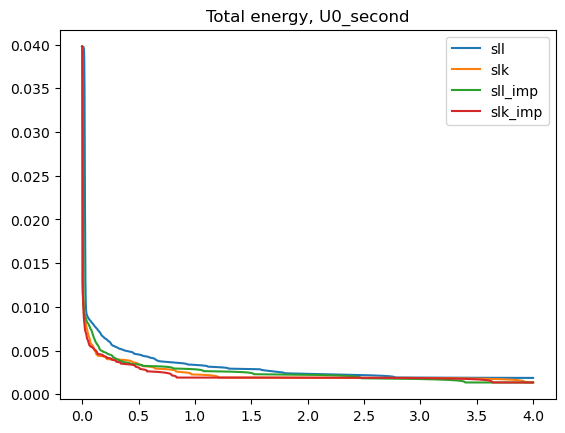

In [182]:
plt.plot(tll,Etot_sll,label='sll')
plt.plot(tlk,Etot_slk,label='slk')
plt.plot(tll,Etot_sll_imp,label='sll_imp')
plt.plot(tlk,Etot_slk_imp,label='slk_imp')
plt.title('Total energy, U0_second')
plt.legend(); plt.show()

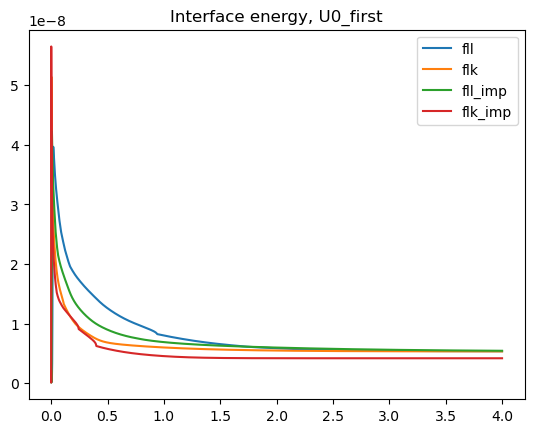

In [188]:
plt.plot(tll,Eint_fll,label='fll')
plt.plot(tlk,Eint_flk,label='flk')
plt.plot(tll,Eint_fll_imp,label='fll_imp')
plt.plot(tlk,Eint_flk_imp,label='flk_imp')
plt.title('Interface energy, U0_first')
plt.legend(); plt.show()

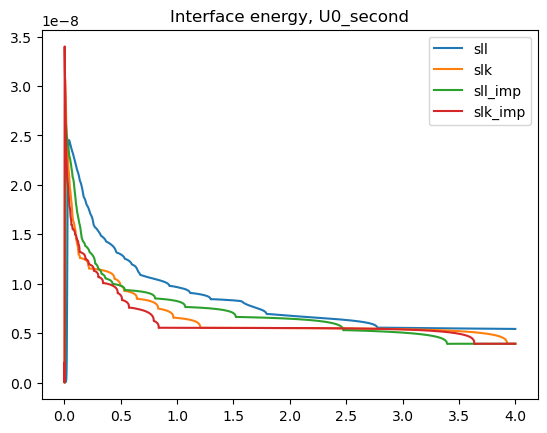

In [191]:
plt.plot(tll,Eint_sll,label='sll')
plt.plot(tlk,Eint_slk,label='slk')
plt.plot(tll,Eint_sll_imp,label='sll_imp')
plt.plot(tlk,Eint_slk_imp,label='slk_imp')
plt.title('Interface energy, U0_second')
plt.legend(); plt.show()

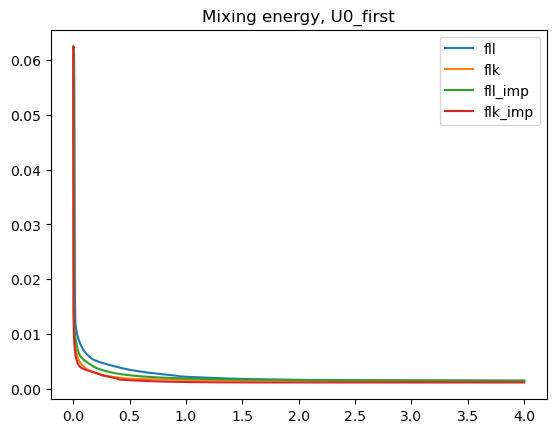

In [192]:
plt.plot(tll,Emix_fll,label='fll')
plt.plot(tlk,Emix_flk,label='flk')
plt.plot(tll,Emix_fll_imp,label='fll_imp')
plt.plot(tlk,Emix_flk_imp,label='flk_imp')
plt.title('Mixing energy, U0_first')
plt.legend(); plt.show()

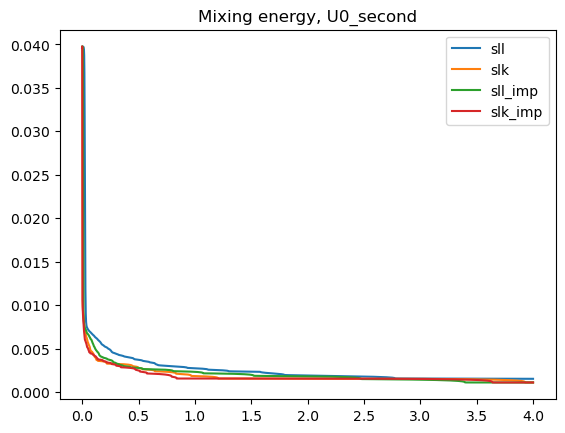

In [193]:
plt.plot(tll,Emix_sll,label='sll')
plt.plot(tlk,Emix_slk,label='slk')
plt.plot(tll,Emix_sll_imp,label='sll_imp')
plt.plot(tlk,Emix_slk_imp,label='slk_imp')
plt.title('Mixing energy, U0_second')
plt.legend(); plt.show()

In [400]:
y = np.array([1,4,5,5,4.5,3,3,3.5,4,5,5,4.5,0.5])
x = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6])
dx = 0.5
print(simpson(y,x))
print(simpson(y,dx=dx))

24.083333333333332
24.083333333333332


In [445]:
z0 = np.array([[0,0,0,0,0,0],[0,0.6,1,1,1,1],[0,0.6,1.2,1.8,2,2],[0,0.6,1.2,1.8,2.4,3]])
z1 = np.array([[0,0,0,0,0,0],[0,0.8,4/3,4/3,4/3,4/3],[0,0.8,1.6,2.4,8/3,8/3],[0,0.8,1.6,2.4,16/5,4]])
z2 = np.array([[0,0,0,0,0,0],[0,1,5/3,5/3,5/3,5/3],[0,1,2,3,10/3,10/3],[0,1,2,3,4,5]])

z = np.array([z0,z1,z2])

print(simpson(simpson(z)))

[14.825      19.76666667 24.70833333]


In [457]:
zINTlist = []
for i in range(len(z)):
    zmid = simpson(z[i])
    zINTlist.append(zmid)
    
zINT = simpson(zINTlist)
print(zINT)

[14.825      19.76666667 24.70833333]


In [200]:
lllN = 200
lllR = len(m_fll)
llln = int(lllR/lllN)
lll = []
count = 0
for i in range(lllR):
    if count % llln == 0:
        lll.append(i)
    count += 1
print(lll)

[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420, 3440, 3460, 3480, 3500,

In [201]:
print(len(lll))

201
